Data augmentation --- 0:00 min
===

* Última modificación: Marzo 1, 2022 | YouTube

Importación de librerías
---

In [1]:
import os

os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"

import tensorflow as tf

Descarga del dataset
---

In [2]:
import tensorflow_datasets as tfds

(train_ds, val_ds, test_ds), metadata = tfds.load(
    "tf_flowers",
    split=["train[:80%]", "train[80%:90%]", "train[90%:]"],
    with_info=True,
    as_supervised=True,
)

In [3]:
num_classes = metadata.features["label"].num_classes
print(num_classes)

5


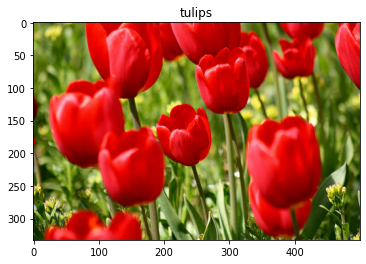

In [4]:
import matplotlib.pyplot as plt

get_label_name = metadata.features["label"].int2str

image, label = next(iter(train_ds))
_ = plt.imshow(image)
_ = plt.title(get_label_name(label))

Uso de capas de preprocesamiento de Keras
---

**Escalado**

In [5]:
IMG_SIZE = 180

resize_and_rescale = tf.keras.Sequential(
    [tf.keras.layers.Resizing(IMG_SIZE, IMG_SIZE), tf.keras.layers.Rescaling(1.0 / 255)]
)

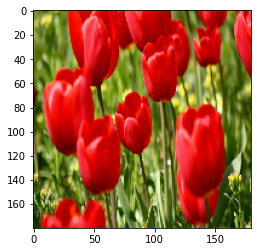

In [6]:
result = resize_and_rescale(image)
_ = plt.imshow(result)

In [7]:
print("Min and max pixel values:", result.numpy().min(), result.numpy().max())

Min and max pixel values: 0.0 1.0


**Data augmentation**

In [8]:
data_augmentation = tf.keras.Sequential(
    [
        tf.keras.layers.RandomFlip("horizontal_and_vertical"),
        tf.keras.layers.RandomRotation(0.2),
    ]
)

In [9]:
image = tf.cast(tf.expand_dims(image, 0), tf.float32)

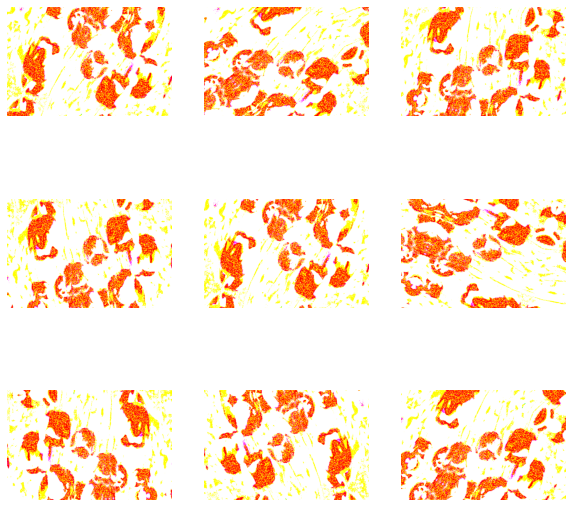

In [10]:
plt.figure(figsize=(10, 10))
for i in range(9):
    augmented_image = data_augmentation(image)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_image[0])
    plt.axis("off")

**Opción 1 para el procesamiento con Keras**

In [11]:
model = tf.keras.Sequential(
    [
        resize_and_rescale,
        data_augmentation,
        tf.keras.layers.Conv2D(
            16,
            3,
            padding="same",
            activation="relu",
        ),
        tf.keras.layers.MaxPooling2D(),
    ]
)

**Opción 2 para el procesamiento con Keras**

In [12]:
aug_ds = train_ds.map(lambda x, y: (resize_and_rescale(x, training=True), y))

**Aplicación de las capas de preprocesamiento a los datasets**

In [13]:
batch_size = 32
AUTOTUNE = tf.data.AUTOTUNE


def prepare(ds, shuffle=False, augment=False):

    ds = ds.map(lambda x, y: (resize_and_rescale(x), y), num_parallel_calls=AUTOTUNE)

    if shuffle:
        ds = ds.shuffle(1000)

    ds = ds.batch(batch_size)

    if augment:
        ds = ds.map(
            lambda x, y: (data_augmentation(x, training=True), y),
            num_parallel_calls=AUTOTUNE,
        )

    return ds.prefetch(buffer_size=AUTOTUNE)

In [14]:
train_ds = prepare(train_ds, shuffle=True, augment=True)
val_ds = prepare(val_ds)
test_ds = prepare(test_ds)

**Entrenamiento del modelo**

In [15]:
model = tf.keras.Sequential(
    [
        tf.keras.layers.Conv2D(16, 3, padding="same", activation="relu"),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Conv2D(32, 3, padding="same", activation="relu"),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Conv2D(64, 3, padding="same", activation="relu"),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation="relu"),
        tf.keras.layers.Dense(num_classes),
    ]
)

In [16]:
model.compile(
    optimizer="adam",
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=["accuracy"],
)

In [ ]:
epochs = 5
history = model.fit(train_ds, validation_data=val_ds, epochs=epochs)

Epoch 1/5
92/92 [==============================] - 26s 265ms/step - loss: 1.4275 - accuracy: 0.3886 - val_loss: 1.2132 - val_accuracy: 0.5613
Epoch 2/5


In [ ]:
loss, acc = model.evaluate(test_ds)
print("Accuracy", acc)

**Personalización del aumento de datos**

In [ ]:
def random_invert_img(x, p=0.5):
    if tf.random.uniform([]) < p:
        x = 255 - x
    else:
        x
    return x

In [ ]:
def random_invert(factor=0.5):
    return layers.Lambda(lambda x: random_invert_img(x, factor))


random_invert = random_invert()

In [ ]:
plt.figure(figsize=(10, 10))
for i in range(9):
    augmented_image = random_invert(image)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_image[0].numpy().astype("uint8"))
    plt.axis("off")

In [ ]:
class RandomInvert(layers.Layer):
    def __init__(self, factor=0.5, **kwargs):
        super().__init__(**kwargs)
        self.factor = factor

    def call(self, x):
        return random_invert_img(x)

In [ ]:
_ = plt.imshow(RandomInvert()(image)[0])

Uso de tf.image
---

In [ ]:
(train_ds, val_ds, test_ds), metadata = tfds.load(
    "tf_flowers",
    split=["train[:80%]", "train[80%:90%]", "train[90%:]"],
    with_info=True,
    as_supervised=True,
)

In [ ]:
image, label = next(iter(train_ds))
_ = plt.imshow(image)
_ = plt.title(get_label_name(label))

In [ ]:
def visualize(original, augmented):
    fig = plt.figure()
    plt.subplot(1, 2, 1)
    plt.title("Original image")
    plt.imshow(original)

    plt.subplot(1, 2, 2)
    plt.title("Augmented image")
    plt.imshow(augmented)

**Data augmentation**

In [ ]:
flipped = tf.image.flip_left_right(image)
visualize(image, flipped)

In [ ]:
grayscaled = tf.image.rgb_to_grayscale(image)
visualize(image, tf.squeeze(grayscaled))
_ = plt.colorbar()

In [ ]:
saturated = tf.image.adjust_saturation(image, 3)
visualize(image, saturated)

In [ ]:
bright = tf.image.adjust_brightness(image, 0.4)
visualize(image, bright)

In [ ]:
bright = tf.image.adjust_brightness(image, 0.4)
visualize(image, bright)

In [ ]:
rotated = tf.image.rot90(image)
visualize(image, rotated)

**Transformaciones aleatorias**

In [ ]:
for i in range(3):
    seed = (i, 0)
    stateless_random_brightness = tf.image.stateless_random_brightness(
        image, max_delta=0.95, seed=seed
    )
    visualize(image, stateless_random_brightness)

In [ ]:
for i in range(3):
    seed = (i, 0)
    stateless_random_contrast = tf.image.stateless_random_contrast(
        image, lower=0.1, upper=0.9, seed=seed
    )
    visualize(image, stateless_random_contrast)

In [ ]:
for i in range(3):
    seed = (i, 0)
    stateless_random_crop = tf.image.stateless_random_crop(
        image, size=[210, 300, 3], seed=seed
    )
    visualize(image, stateless_random_crop)

**Aplicación de la aumentación de datos al dataset**

In [ ]:
(train_datasets, val_ds, test_ds), metadata = tfds.load(
    "tf_flowers",
    split=["train[:80%]", "train[80%:90%]", "train[90%:]"],
    with_info=True,
    as_supervised=True,
)

In [ ]:
def resize_and_rescale(image, label):
    image = tf.cast(image, tf.float32)
    image = tf.image.resize(image, [IMG_SIZE, IMG_SIZE])
    image = image / 255.0
    return image, label

In [ ]:
def augment(image_label, seed):
    image, label = image_label
    image, label = resize_and_rescale(image, label)
    image = tf.image.resize_with_crop_or_pad(image, IMG_SIZE + 6, IMG_SIZE + 6)
    # Make a new seed.
    new_seed = tf.random.experimental.stateless_split(seed, num=1)[0, :]
    # Random crop back to the original size.
    image = tf.image.stateless_random_crop(
        image, size=[IMG_SIZE, IMG_SIZE, 3], seed=seed
    )
    # Random brightness.
    image = tf.image.stateless_random_brightness(image, max_delta=0.5, seed=new_seed)
    image = tf.clip_by_value(image, 0, 1)
    return image, label

In [ ]:
#
# Uso de tf.data.experimental.Counter
#
counter = tf.data.experimental.Counter()
train_ds = tf.data.Dataset.zip((train_datasets, (counter, counter)))

In [ ]:
train_ds = (
    train_ds.shuffle(1000)
    .map(augment, num_parallel_calls=AUTOTUNE)
    .batch(batch_size)
    .prefetch(AUTOTUNE)
)

In [ ]:
val_ds = (
    val_ds.map(resize_and_rescale, num_parallel_calls=AUTOTUNE)
    .batch(batch_size)
    .prefetch(AUTOTUNE)
)

In [ ]:
test_ds = (
    test_ds.map(resize_and_rescale, num_parallel_calls=AUTOTUNE)
    .batch(batch_size)
    .prefetch(AUTOTUNE)
)

In [ ]:
#
# Uso de tf.random.Generator
#
rng = tf.random.Generator.from_seed(123, alg="philox")

In [ ]:
# Create a wrapper function for updating seeds.
def f(x, y):
    seed = rng.make_seeds(2)[0]
    image, label = augment((x, y), seed)
    return image, label

In [ ]:
train_ds = (
    train_datasets.shuffle(1000)
    .map(f, num_parallel_calls=AUTOTUNE)
    .batch(batch_size)
    .prefetch(AUTOTUNE)
)

In [ ]:
val_ds = (
    val_ds.map(resize_and_rescale, num_parallel_calls=AUTOTUNE)
    .batch(batch_size)
    .prefetch(AUTOTUNE)
)

In [ ]:
test_ds = (
    test_ds.map(resize_and_rescale, num_parallel_calls=AUTOTUNE)
    .batch(batch_size)
    .prefetch(AUTOTUNE)
)